In [185]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import IsolationForest
from scipy.stats import f_oneway


In [186]:
df = pd.read_csv('train.csv')

In [187]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [189]:
# remove leading "conditions " in Weatherconditions and "(min) " in Time_taken(min)
df['Time_taken(min)'] = df['Time_taken(min)'].str.replace('(min) ','')
df['Weatherconditions'] = df['Weatherconditions'].str.replace('conditions ','')

In [190]:
#Fixing the data type of columns
numeric_columns = ["Delivery_person_Age", "Delivery_person_Ratings", "multiple_deliveries", "Time_taken(min)"]

for column in numeric_columns:
    df[column] = df[column].astype(float)

In [191]:
#Remove Duplicates
df.duplicated().sum()
#No duplicates

0

In [192]:
#Find missing values
#Identify 'NaN' and 'NaN ' values

df.replace("NaN ", np.nan, inplace=True)
df.replace("NaN", np.nan, inplace=True)
df.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

In [193]:
#Since nan values are very few compare to data set we not gonna impute them. We simply drop them.
df.dropna(inplace=True)

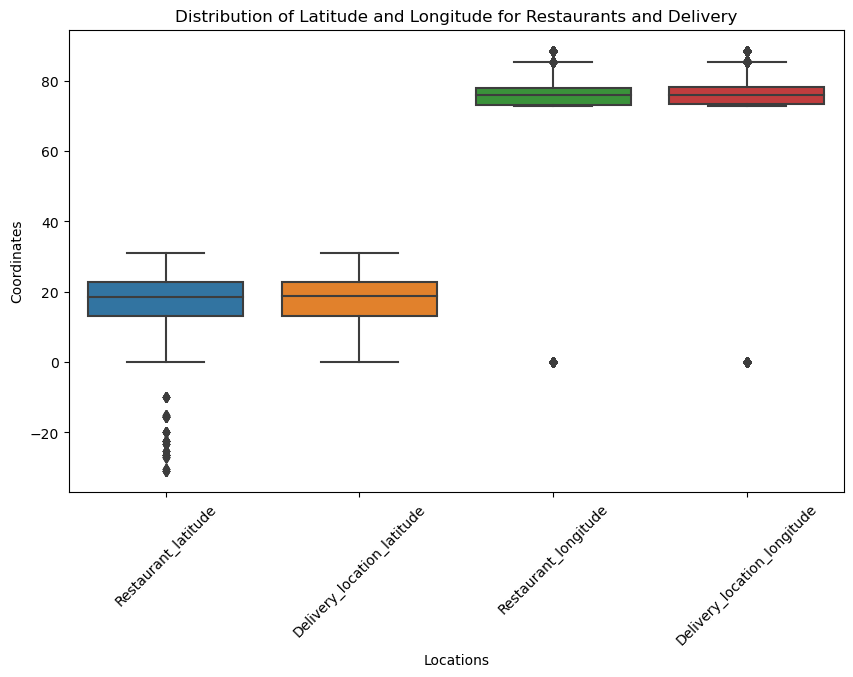

In [194]:
#latitude and longitude analysis

plot_loc = df.melt(value_vars=['Restaurant_latitude', 'Delivery_location_latitude', 'Restaurant_longitude', 'Delivery_location_longitude'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', data= plot_loc)
plt.ylabel('Coordinates')
plt.xlabel('Locations')
plt.title('Distribution of Latitude and Longitude for Restaurants and Delivery')
plt.xticks(rotation=45)

plt.show()

In [195]:
#This data are related to india. Therefore latitude and longitude must be in range [8.4,37.6] , [68.7,97.25]
#We can see some unusual observations. We can remove those.

df = df[
    (df['Restaurant_latitude'].between(8.4, 37.6, inclusive='both')) &
    (df['Delivery_location_latitude'].between(8.4, 37.6, inclusive='both'))
]

df = df[
    (df['Restaurant_longitude'].between(68.7, 97.25, inclusive='both')) &
    (df['Delivery_location_longitude'].between(68.7, 97.25, inclusive='both'))
]


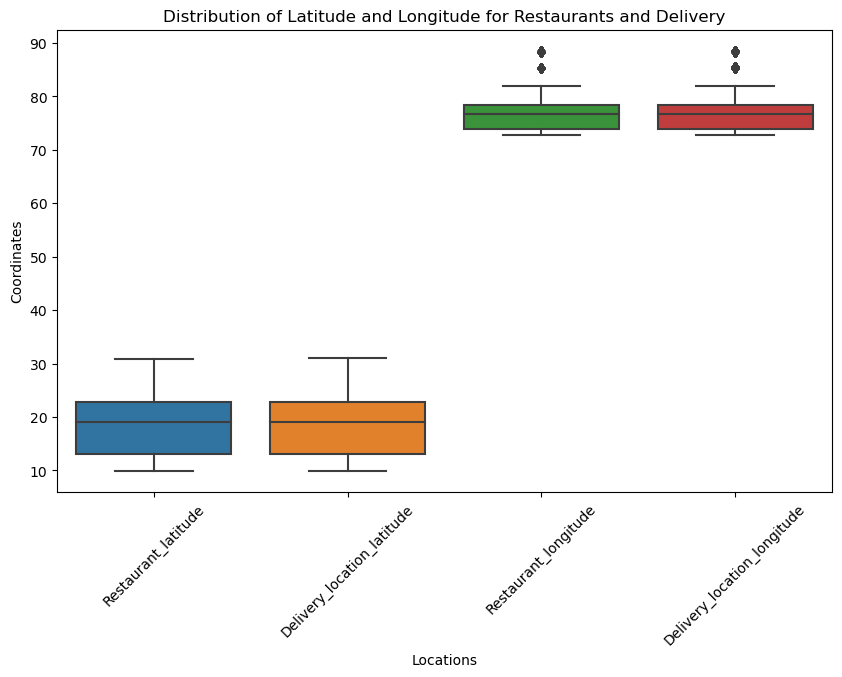

In [196]:
#After removing unusual observations.
plot_loc = df.melt(value_vars=['Restaurant_latitude', 'Delivery_location_latitude', 'Restaurant_longitude', 'Delivery_location_longitude'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', data= plot_loc)
plt.ylabel('Coordinates')
plt.xlabel('Locations')
plt.title('Distribution of Latitude and Longitude for Restaurants and Delivery')
plt.xticks(rotation=45)

plt.show()

In [197]:
#Feature Engineering
#We can engineer Delivery_City from Delivery_person_ID and we can calculate the distance between resturent and delivery location

df['Delivery_City'] = df['Delivery_person_ID'].str[:4]

In [198]:
#vincenty distance formula can be use to find the distance between restuarent and delivery location
def vincenty_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the Earth's surface
    using the Vincenty formula.

    Parameters:
    - lat1, lon1: Latitude and Longitude of the first point.
    - lat2, lon2: Latitude and Longitude of the second point.

    Returns:
    - Distance in kilometers between the two points.
    """

    # WGS-84 ellipsoidal parameters
    a = 6378137.0  # semi-major axis in meters
    f = 1 / 298.257223563  # flattening
    b = (1 - f) * a  # semi-minor axis

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    U1 = math.atan((1 - f) * math.tan(lat1))
    U2 = math.atan((1 - f) * math.tan(lat2))

    L = lon2 - lon1
    Lambda = L
    sinU1 = math.sin(U1)
    cosU1 = math.cos(U1)
    sinU2 = math.sin(U2)
    cosU2 = math.cos(U2)

    # Iterate till change in lambda is insignificant
    for _ in range(1000):
        sinLambda = math.sin(Lambda)
        cosLambda = math.cos(Lambda)
        sinSigma = math.sqrt((cosU2 * sinLambda)**2 + (cosU1 * sinU2 - sinU1 * cosU2 * cosLambda)**2)
        cosSigma = sinU1 * sinU2 + cosU1 * cosU2 * cosLambda
        sigma = math.atan2(sinSigma, cosSigma)
        sinAlpha = cosU1 * cosU2 * sinLambda / sinSigma
        cos2Alpha = 1 - sinAlpha**2
        cos2SigmaM = cosSigma - 2 * sinU1 * sinU2 / cos2Alpha
        C = f / 16 * cos2Alpha * (4 + f * (4 - 3 * cos2Alpha))
        Lambda_prev = Lambda
        Lambda = L + (1 - C) * f * sinAlpha * (sigma + C * sinSigma * (cos2SigmaM + C * cosSigma * (-1 + 2 * cos2SigmaM**2)))

        # Break if change in lambda is insignificant
        if abs(Lambda - Lambda_prev) < 1e-12:
            break

    u2 = cos2Alpha * (a**2 - b**2) / (b**2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))
    deltaSigma = B * sinSigma * (cos2SigmaM + B / 4 * (cosSigma * (-1 + 2 * cos2SigmaM**2) - B / 6 * cos2SigmaM * (-3 + 4 * sinSigma**2) * (-3 + 4 * cos2SigmaM**2)))

    # Distance in meters
    s = b * A * (sigma - deltaSigma)

    # Convert to kilometers
    return (s/1000)

df['Distance'] = df.apply(
    lambda row: vincenty_distance(
        row['Restaurant_latitude'], row['Restaurant_longitude'],
        row['Delivery_location_latitude'], row['Delivery_location_longitude']
    ),
    axis=1
)

In [199]:
#Remove ID and Delivery_person_ID because those have not significant importance for modeling
df.drop(columns=["ID","Delivery_person_ID"], inplace=True)

In [200]:
#There are no exact importance of exact time or date of Time_Orderd, Time_Order_picked and Order_Date for modeling. Therefore we recode those variable to which hour (0 -> 00:00, 23 -> 23:00) and date of the year
df["Time_Orderd"] = df["Time_Orderd"].str.split(':').str[0].astype(int)
df["Time_Order_picked"] = df["Time_Order_picked"].str.split(':').str[0].astype(int)

df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y')
df['Order_Date'] = df['Order_Date'].dt.dayofyear

In [201]:
#Supportive functions
def plot_data_bar_plot(df, column_name, title_size=14, axis_size=12, tick_size=10):
    plt.figure(figsize=(12, 4))
    sns.countplot(data=df, x=column_name, palette="husl")
    plt.title(f'Barplot of {column_name}', fontsize=title_size)
    plt.ylabel('Count', fontsize=axis_size)
    plt.xlabel(column_name, fontsize=axis_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.show()

def plot_data_histogram(df, column_name, title_size=14, axis_size=12, tick_size=10, bins = 5):
    plt.figure(figsize=(13, 4))
    sns.histplot(df[column_name],bins = bins, color = 'orange')
    plt.title(f'Histogram of {column_name}', fontsize=title_size)
    plt.xlabel(column_name, fontsize=axis_size)
    plt.ylabel('Frequency', fontsize=axis_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.show()

def plot_data_boxplot(df, column_name1,column_name2 ,title_size=14, axis_size=12, tick_size=10):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column_name1],y=df[column_name2],palette="husl")
    plt.title(f'Boxplot of {column_name1} with {column_name2}', fontsize=title_size)
    plt.xlabel(column_name1, fontsize=axis_size)
    plt.ylabel(column_name2, fontsize=axis_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.show()

def plot_data_scatter(df, column_name1,column_name2 ,title_size=14, axis_size=12, tick_size=10):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[column_name1],y=df[column_name2],palette="husl")
    plt.title(f'Boxplot of {column_name1} with {column_name2}', fontsize=title_size)
    plt.xlabel(column_name1, fontsize=axis_size)
    plt.ylabel(column_name2, fontsize=axis_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.show()

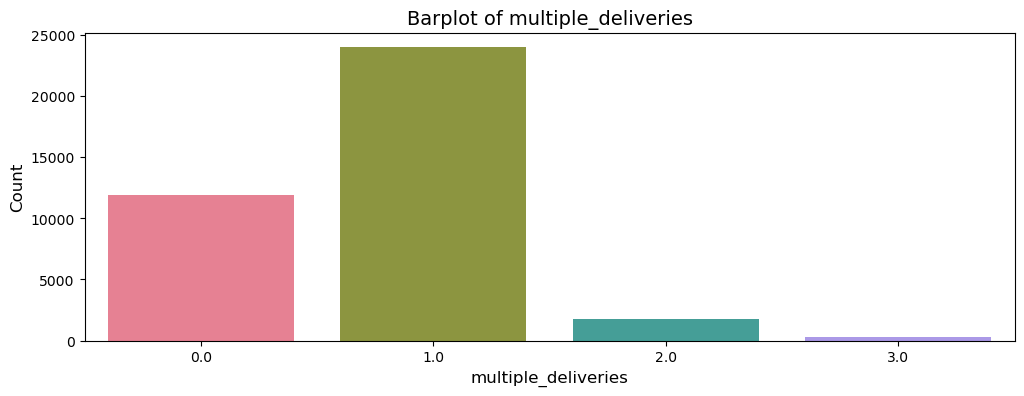

In [202]:
#Multiple Delivery distribution
plot_data_bar_plot(df, 'multiple_deliveries')

In [205]:
value_counts = df["multiple_deliveries"].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
print(percentages)

one = df[df['multiple_deliveries'] == 1.0]['Time_taken(min)']
two = df[df['multiple_deliveries'] == 2.0]['Time_taken(min)']
three = df[df['multiple_deliveries'] == 3.0]['Time_taken(min)']


f_statistic1, p_value1 = f_oneway(one, two)
print("F-statistic:", f_statistic1)
print("p-value:", p_value1)

f_statistic2, p_value2 = f_oneway(one, three)
print("F-statistic:", f_statistic2)
print("p-value:", p_value2)

f_statistic3, p_value3 = f_oneway(two, three)
print("F-statistic:", f_statistic3)
print("p-value:", p_value3)

#Hence there is significant deference with 1,2,3


multiple_deliveries
1.0    63.286566
0.0    31.317580
2.0     4.591487
3.0     0.804367
Name: count, dtype: float64
F-statistic: 4266.705144451736
p-value: 0.0
F-statistic: 1838.6122732995982
p-value: 0.0
F-statistic: 641.1688589108284
p-value: 2.8804876146458312e-123


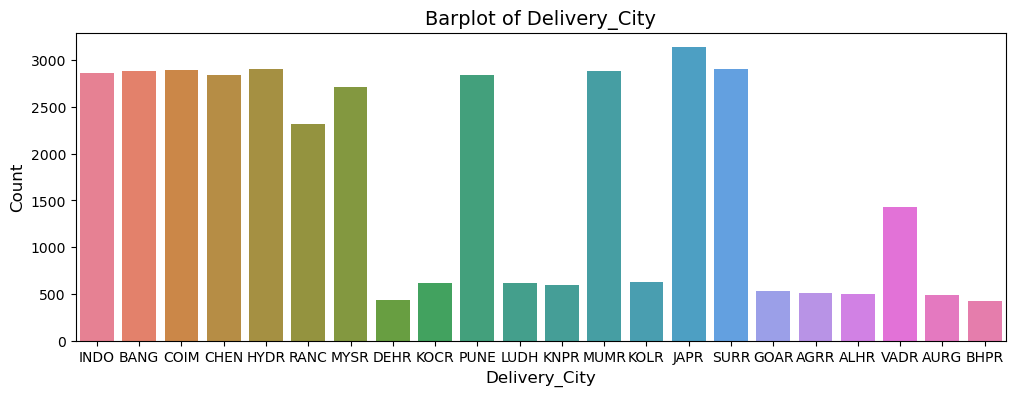

In [206]:
plot_data_bar_plot(df, 'Delivery_City')

In [207]:
value_counts = df["Delivery_City"].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
print(percentages)

#Compare to other every category has significat reprecentation

Delivery_City
JAPR    8.273116
SURR    7.669181
HYDR    7.661269
COIM    7.640171
MUMR    7.595337
BANG    7.590063
INDO    7.542592
PUNE    7.487209
CHEN    7.476660
MYSR    7.160188
RANC    6.100005
VADR    3.776570
KOLR    1.637745
KOCR    1.632470
LUDH    1.624558
KNPR    1.569176
GOAR    1.389841
AGRR    1.331821
ALHR    1.323909
AURG    1.273801
DEHR    1.134026
BHPR    1.110291
Name: count, dtype: float64


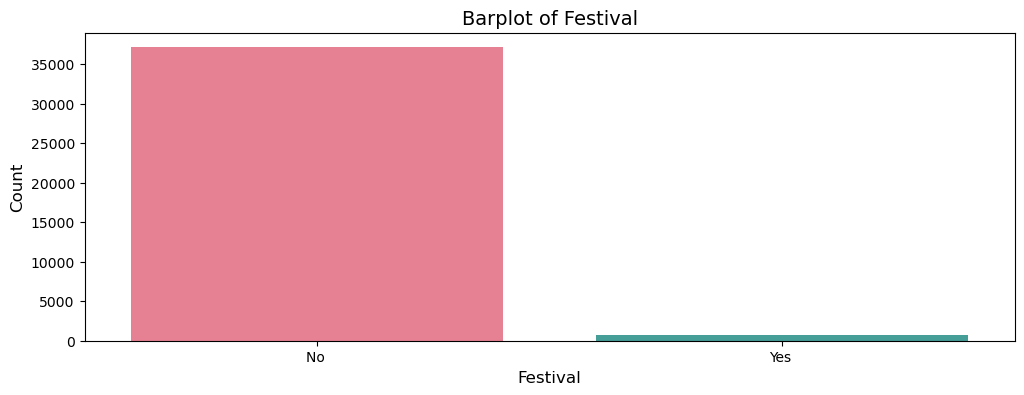

In [208]:
plot_data_bar_plot(df, 'Festival')

In [210]:
value_counts = df["Festival"].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
print(percentages)

no = df[df['Festival'] == "No "]['Time_taken(min)']
yes = df[df['Festival'] == "Yes "]['Time_taken(min)']


f_statistic1, p_value1 = f_oneway(no, yes)
print("F-statistic:", f_statistic1)
print("p-value:", p_value1)

#Hence there is significant deference between no and yes

Festival
No      97.982489
Yes      2.017511
Name: count, dtype: float64
F-statistic: 3502.876587899137
p-value: 0.0


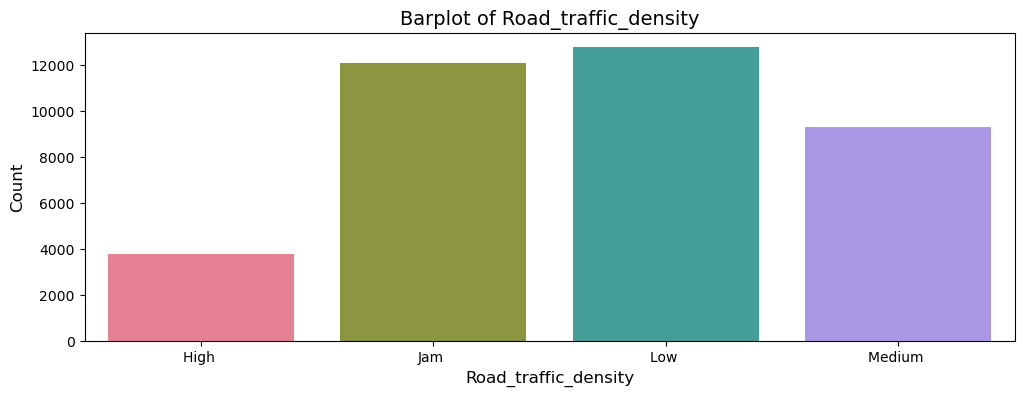

In [211]:
plot_data_bar_plot(df, 'Road_traffic_density')

In [212]:
value_counts = df["Road_traffic_density"].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
print(percentages)

#All categories have considerable percentage of data. Since this is ordinal variable we can recode this as (low -> 0, medium ->1, high ->2, jam ->3)
mapping = {'Low ': 0, 'Medium ': 1, 'High ': 2, 'Jam ': 3}
df['Road_traffic_density'] = df['Road_traffic_density'].replace(mapping)


Road_traffic_density
Low        33.691123
Jam        31.895142
Medium     24.521336
High        9.892399
Name: count, dtype: float64


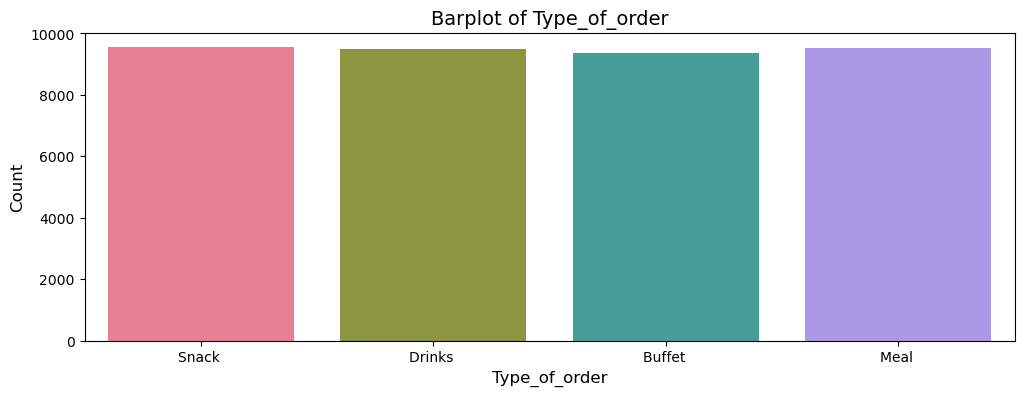

In [213]:
plot_data_bar_plot(df, 'Type_of_order')

In [214]:
value_counts = df["Type_of_order"].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
print(percentages)

Type_of_order
Snack      25.175378
Meal       25.138457
Drinks     24.996044
Buffet     24.690121
Name: count, dtype: float64


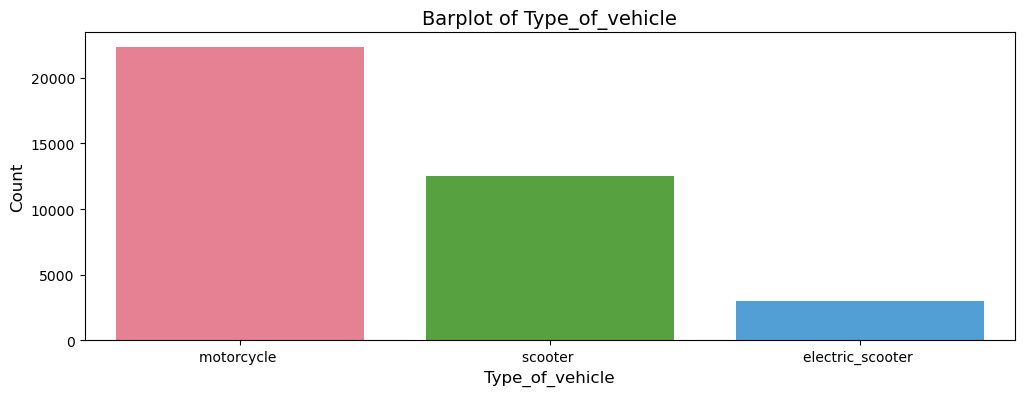

In [161]:
plot_data_bar_plot(df, 'Type_of_vehicle')

In [215]:
value_counts = df["Type_of_vehicle"].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
print(percentages)

#electric scooter category has relatively low percentage. We can do anova test and can find out wheter there is any significat difference between scooter and electric_scooter categories

Type_of_vehicle
motorcycle           58.924521
scooter              33.108286
electric_scooter      7.967192
Name: count, dtype: float64


In [216]:
scooter = df[df['Type_of_vehicle'] == 'scooter ']['Time_taken(min)']
electric_scooter = df[df['Type_of_vehicle'] == 'electric_scooter ']['Time_taken(min)']

f_statistic, p_value = f_oneway(scooter, electric_scooter)

print("F-statistic:", f_statistic)
print("p-value:", p_value)

#Do not reject H0 Hence there are no significat difference between 2 categories. Hence we can add both together and say scooter
df['Type_of_vehicle'] = df['Type_of_vehicle'].replace(['electric_scooter '], 'scooter ')


F-statistic: 1.1076514507377164
p-value: 0.29260937102385


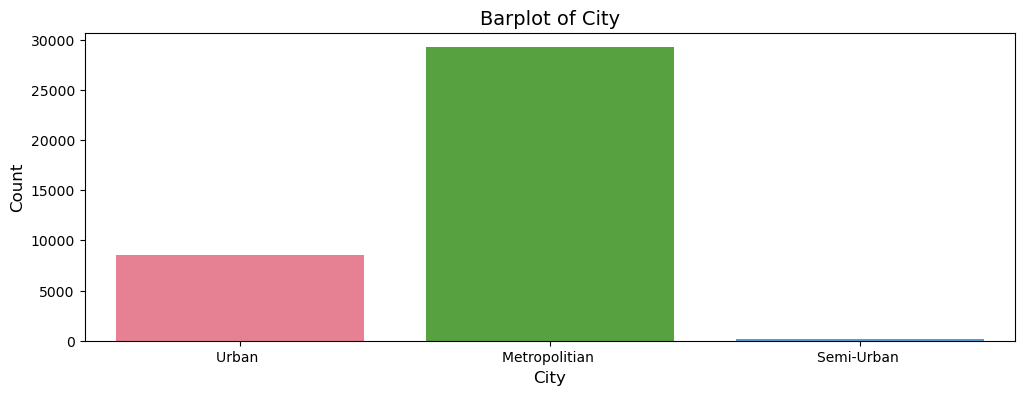

In [173]:
plot_data_bar_plot(df, 'City')

In [217]:
value_counts = df["City"].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
print(percentages)

#Semi-Urban has very small percentage. Lets check wheather there is significant difference between Urban and semi-urban

City
Metropolitian     77.061026
Urban             22.575030
Semi-Urban         0.363943
Name: count, dtype: float64


In [218]:
Urban = df[df['City'] == 'Urban ']['Time_taken(min)']
SemiUrban = df[df['City'] == 'Semi-Urban ']['Time_taken(min)']
Metropolitian = df[df['City'] == 'Metropolitian ']['Time_taken(min)']

f_statistic1, p_value1 = f_oneway(Urban, SemiUrban)
f_statistic2, p_value2 = f_oneway(Metropolitian, SemiUrban)

print("F-statistic:", f_statistic1)
print("p-value:", p_value1)

print("F-statistic:", f_statistic2)
print("p-value:", p_value2)

#Reject H0 for both cases. Hence we do not remove semi-urban. But city is ordinal variable. We can encode this as (semi-urban -> 0, urban -> 1, metropolitian -> 2)

mapping = {'Semi-Urban ': 0, 'Urban ': 1, 'Metropolitian ': 2}
df['City'] = df['City'].replace(mapping)

F-statistic: 1223.6015397414074
p-value: 6.176770243532738e-251
F-statistic: 816.4986475388722
p-value: 3.731294615828991e-177


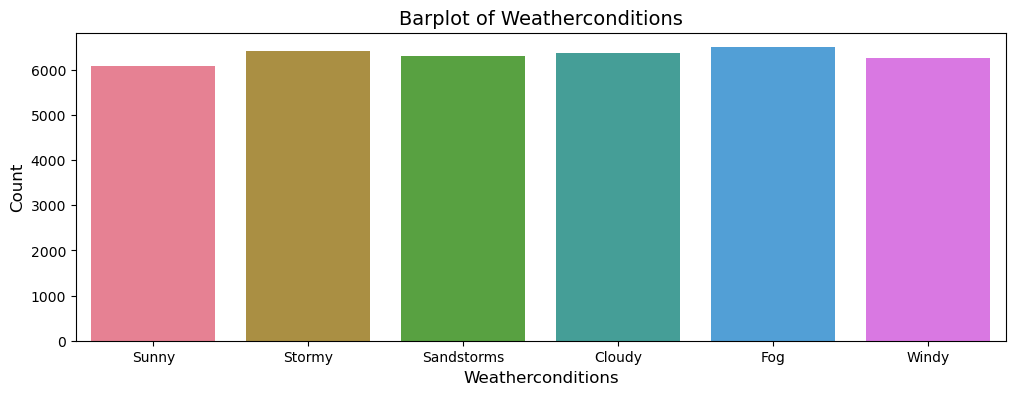

In [219]:
plot_data_bar_plot(df, 'Weatherconditions')

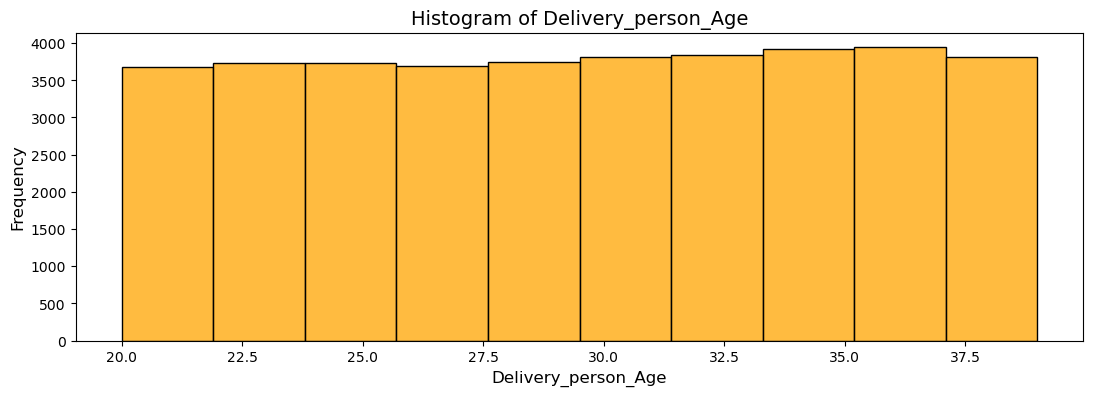

In [221]:
plot_data_histogram(df, 'Delivery_person_Age',bins = 10)

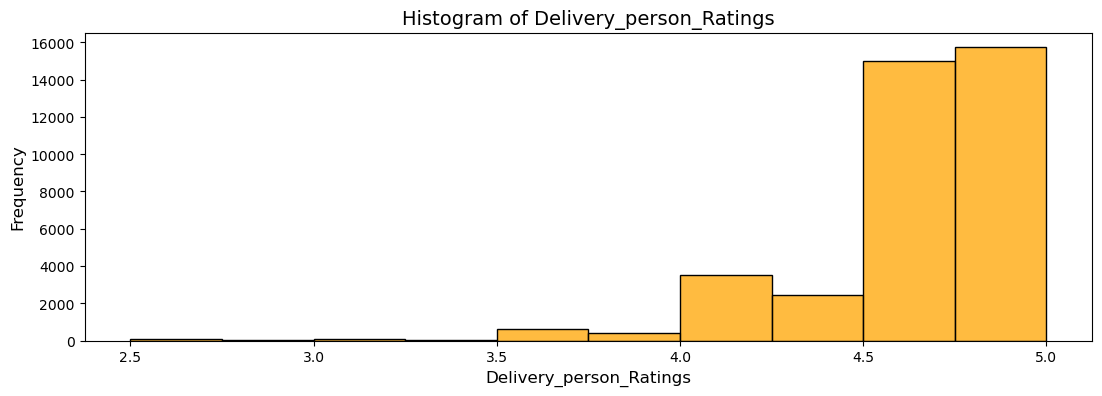

In [223]:
plot_data_histogram(df, 'Delivery_person_Ratings', bins =10)

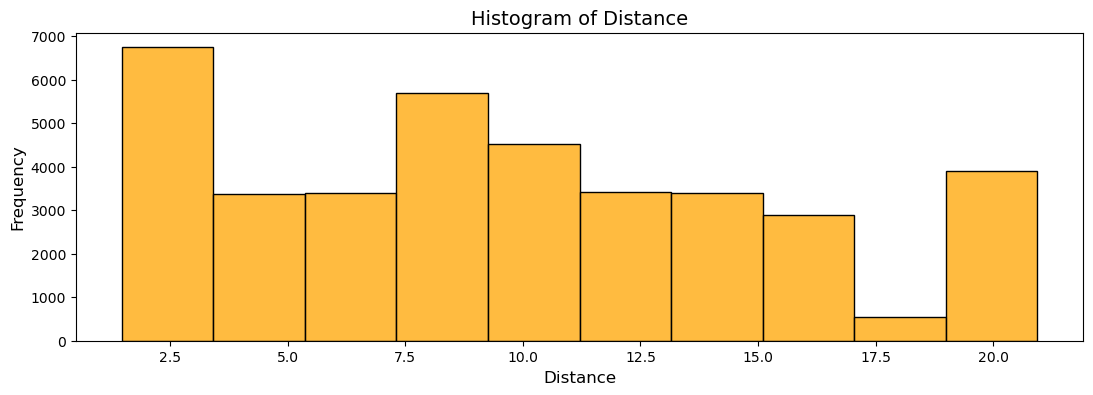

In [226]:
plot_data_histogram(df, 'Distance', bins = 10)

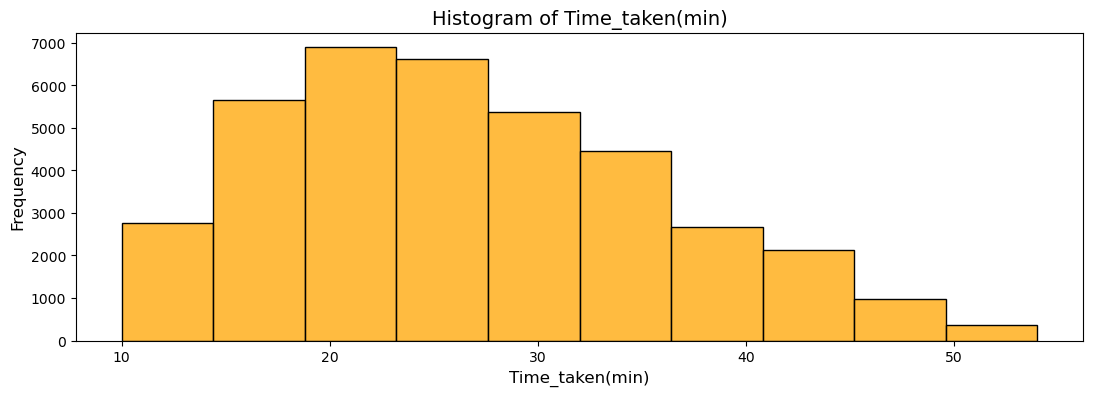

In [229]:
plot_data_histogram(df, 'Time_taken(min)', bins=10) #Response

In [ ]:
################################################3333

In [234]:
dft = df.drop(columns=['Delivery_City'])

In [235]:
dft

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,78,11,11,Sunny,2,2,Snack,motorcycle,0.0,No,1,24.0,3.020737
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,84,19,19,Stormy,3,2,Snack,scooter,1.0,No,2,33.0,20.143737
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,78,8,8,Sandstorms,0,0,Drinks,motorcycle,1.0,No,1,26.0,1.549693
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,95,18,18,Sunny,1,0,Buffet,motorcycle,1.0,No,2,21.0,7.774497
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,85,13,13,Cloudy,2,1,Snack,scooter,1.0,No,2,30.0,6.197898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45587,35.0,4.2,23.371292,85.327872,23.481292,85.437872,67,21,21,Windy,3,2,Drinks,motorcycle,1.0,No,2,33.0,16.576800
45588,30.0,4.8,26.902328,75.794257,26.912328,75.804257,83,11,11,Windy,2,1,Meal,motorcycle,0.0,No,2,32.0,1.488112
45590,30.0,4.9,13.022394,80.242439,13.052394,80.272439,70,23,0,Cloudy,0,1,Drinks,scooter,0.0,No,2,16.0,4.648024
45591,20.0,4.7,11.001753,76.986241,11.041753,77.026241,66,13,13,Cloudy,2,0,Snack,motorcycle,1.0,No,2,26.0,6.219668
